In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

pd.set_option('display.max_columns', None)

In [ ]:
#Read data
df = pd.read_csv('./data/data.csv')

# Separate location and data information
df_data = df.iloc[9:].copy()
df_loc = df.iloc[:8].copy()

# Clean location information for display purposes
df_loc = df_loc.transpose()
df_loc.columns = df_loc.iloc[0]
df_loc = df_loc.drop(df_loc.index[0])
df_loc.rename(columns={'Site name': 'Index_'}, inplace=True)
df_loc['years_with_data'] = (df_loc['Last year CE'].astype(int)
                             - df_loc['First year CE'].astype(int)
                             + 1
                             )
df_loc['Site  name'] = df_loc['Site  name'].str[:23]
df_loc.reset_index(inplace=True)
df_loc.rename(columns={'index': 'site_code',
                       'Site  name': 'site_name'},
              inplace=True
              )

# Plot years with data according to location
fig = px.scatter_geo(df_loc,
                    lat=df_loc.Latitude,
                    lon=df_loc.Longitude,
                    color='site_name',
                    size="years_with_data",
                     )
fig.update_geos(
    center={"lat": df_loc["Latitude"].astype(float).mean(),
            "lon": df_loc["Longitude"].astype(float).mean()},
    projection_scale=4
)

fig.update_layout(title_text='Number of years with data according to location')
fig.show()


In [ ]:
df_loc

Site Code,site_code,site_name,Country,Latitude,Longitude,Species,First year CE,Last year CE,elevation a.s.l.,years_with_data
0,BRO,Bromarv,Finland,60,23.08,Quercus robur,1901,2002,5,102
1,CAV,Cavergno,Switzerland,46.35,8.6,Quercus petraea,1637,2002,900,366
2,CAZ,Cazorla,Spain,37.93,-2.97,Pinus nigra,1600,2002,1820,403
3,COL,Col Du Zad,Morocco,32.97,-5.07,Cedrus atlantica,1600,2000,2200,401
4,DRA,Dransfeld,Germany,51.51,9.78,Quercus petraea,1776,1999,320,224
5,FON,Fontainebleau,France,48.38,2.67,Quercus petraea,1600,2000,100,401
6,GUT,Gutuli,Norway,62,12.18,Pinus sylvestris,1600,2003,800,404
7,ILO,Sivakkovaara,Finland,62.98,31.27,Pinus sylvestris,1600,2002,200,403
8,INA,Inari,Finland,68.93,28.31,Pinus sylvestris,1600,2002,150,403
9,AHI,Perchtoldsdorf Wehrturm,Austria,48.25,16.77,Quercus petraea,1600,1883,n.s.,284


In [ ]:
# Clean data information
df_data.rename(columns={'Site Code': 'year'}, inplace=True)
df_data.set_index('year', inplace=True)
df_data = df_data.transpose().reset_index()
df_data.rename(columns={'index': 'site_code'}, inplace=True)
df_data = df_data.melt(id_vars=['site_code'], var_name='Year', value_name='Value')
df_data.sort_values(by=['site_code', 'Year'], inplace=True, ignore_index=True)

# Identify problematic entries in 'Value' column
mask_invalid = pd.to_numeric(df_data['Value'].str.strip(), errors='coerce').isna()
errores = df_data.loc[mask_invalid, 'Value']
print("Problematic entries in registered 'Value' column:")
l_problematic_entries = errores.unique().tolist()
print(l_problematic_entries)

# This will be done since all problematic entries are some form of NaN
df_data['Value'] = df_data['Value'].replace(
    ['nan', 'NaN', 'NAN'], np.nan
)

Problematic entries in registered 'Value' column:
[nan, 'NA ', 'NAN']


In [ ]:
# After EDA, we found that 'NA' strings are used to denote missing data
df_data['Value'] = pd.to_numeric(df_data['Value'].str.strip(), errors='coerce')

# Compare number of data points per site with number of years with data
df_data_value_counts = df_data.groupby('site_code', as_index=False).count()
df_data_value_counts.columns = [col if col == 'site_code'
                                else col + '_count'
                                for col in df_data_value_counts.columns
                                ]
df_data_value_counts = df_data_value_counts.merge(
    					df_loc[['site_code', 'years_with_data']],
                        on='site_code', how='left'
                        )
df_data_value_counts['missing_data'] = (df_data_value_counts['Value_count']
                                        < df_data_value_counts['years_with_data'])*1

print("Number of sites with missing data: "
      f"{df_data_value_counts['missing_data'].sum()} out of "
      f"{df_data_value_counts.shape[0]} total sites")

df_data_value_counts['percentage_missing'] = (1
                                              - (df_data_value_counts['Value_count']
                                                 /df_data_value_counts['years_with_data'])
                                                 )*100

Number of sites with missing data: 10 out of 25 total sites


In [ ]:
df_significant_missing_data = df_data_value_counts[df_data_value_counts.percentage_missing > 6].reset_index(drop=True)
df_low_missing_data = df_data_value_counts[(df_data_value_counts.percentage_missing <= 6) & (df_data_value_counts.percentage_missing > 0)].reset_index(drop=True)
df_more_data = df_data_value_counts[df_data_value_counts.percentage_missing < 0].reset_index(drop=True)

In [ ]:
df_significant_missing_data


,site_code,Year_count,Value_count,years_with_data,missing_data,percentage_missing
0,COL,406,280,401,1,30.174564
1,FON,406,283,401,1,29.426434


In [ ]:
df_more_data

,site_code,Year_count,Value_count,years_with_data,missing_data,percentage_missing
0,DRA,406,226,224,0,-0.892857


In [ ]:
l_hard_review = df_significant_missing_data['site_code'].tolist()
l_more_data = df_more_data['site_code'].tolist()

In [ ]:
for i in l_hard_review:
    aux = df_data[df_data['site_code'] == i].reset_index(drop=True)
    fig = px.line(aux, x='Year', y='Value', title=f'Site code: {i}')
    fig.show()

In [ ]:
l_low_review = df_low_missing_data['site_code'].tolist()

for i in l_low_review:
    aux = df_data[(df_data['site_code'] == i)].reset_index(drop=True)

    fig = px.line(aux, x='Year', y='Value', title=f'Site code: {i}')
    fig.show()

In [ ]:
l_review = l_hard_review + l_low_review+l_more_data
l_no_problem = list(df_data.site_code.unique())
l_no_problem = [i for i in l_no_problem if i not in l_review]

In [ ]:
for i in l_no_problem:
    aux = df_data[df_data['site_code'] == i].reset_index(drop=True)
    fig = px.line(aux, x='Year', y='Value', title=f'Site code: {i}')
    fig.show()

In [ ]:
# Standarization of SER and POE Site codes
df_caz = df_data[(df_data['site_code'] == 'CAZ ') & (df_data['Value'].notna())].reset_index(drop=True)
df_caz['min_max'] = (df_caz['Value'] - df_caz['Value'].min()) / (df_caz['Value'].max() - df_caz['Value'].min())
df_caz['z_score'] = (df_caz['Value'] - df_caz['Value'].mean()) / df_caz['Value'].std(ddof=0)

df_poe = df_data[(df_data['site_code'] == 'POE ') & (df_data['Value'].notna())].reset_index(drop=True)
df_poe['min_max'] = (df_poe['Value'] - df_poe['Value'].min()) / (df_poe['Value'].max() - df_poe['Value'].min())
df_poe['z_score'] = (df_poe['Value'] - df_poe['Value'].mean()) / df_poe['Value'].std(ddof=0)

df_caz

,site_code,Year,Value,min_max,z_score
0,CAZ,1600,-21.1,0.680851,-0.081777
1,CAZ,1601,-21.0,0.702128,0.080568
2,CAZ,1602,-20.9,0.723404,0.242913
3,CAZ,1603,-20.9,0.723404,0.242913
4,CAZ,1604,-21.7,0.553191,-1.055845
...,...,...,...,...,...
398,CAZ,1998,-22.3,0.425532,-2.029913
399,CAZ,1999,-22.8,0.319149,-2.841637
400,CAZ,2000,-22.3,0.425532,-2.029913
401,CAZ,2001,-22.2,0.446809,-1.867569


In [ ]:
import matplotlib.pyplot as plt

# Combine data for plotting
df_combined = pd.concat([df_caz, df_poe], ignore_index=True)

# Melt the DataFrame to long format for plotly
df_long_mm = df_combined.melt(id_vars=['site_code'], value_vars=['min_max'],
                           var_name='Standardization', value_name='Standardized_Value')

# Create boxplot
fig = px.box(df_long_mm, x='site_code', y='Standardized_Value',
             title='Min-Max standardization Boxplot for CAZ and POE',)
fig.show()

In [ ]:
# Melt the DataFrame to long format for plotly
df_long_z = df_combined.melt(id_vars=['site_code'], value_vars=['z_score'],
                           var_name='Standardization', value_name='Standardized_Value')

# Create boxplot
fig = px.box(df_long_z, x='site_code', y='Standardized_Value',
             title='Z-score standardization Boxplot for CAZ and POE',)
fig.show()

In [ ]:
fig = px.scatter(
    df_combined,
    x='Year',
    y='Value',
    color='site_code',
    title='Scatter plot for CAZ and POE'
)
fig.show()

In [ ]:
# Merge por año
df_merge = pd.merge(
    df_caz[['Year', 'Value']],
    df_poe[['Year', 'Value']],
    on='Year',
    suffixes=('_CAZ', '_POE')
)

# Scatter plot
fig = px.scatter(
    df_merge,
    x='Value_CAZ',
    y='Value_POE',
    title='POE vs CAZ by year',
    labels={'Value_CAZ': 'CAZ Value', 'Value_POE': 'POE Value'}
)
fig.show()

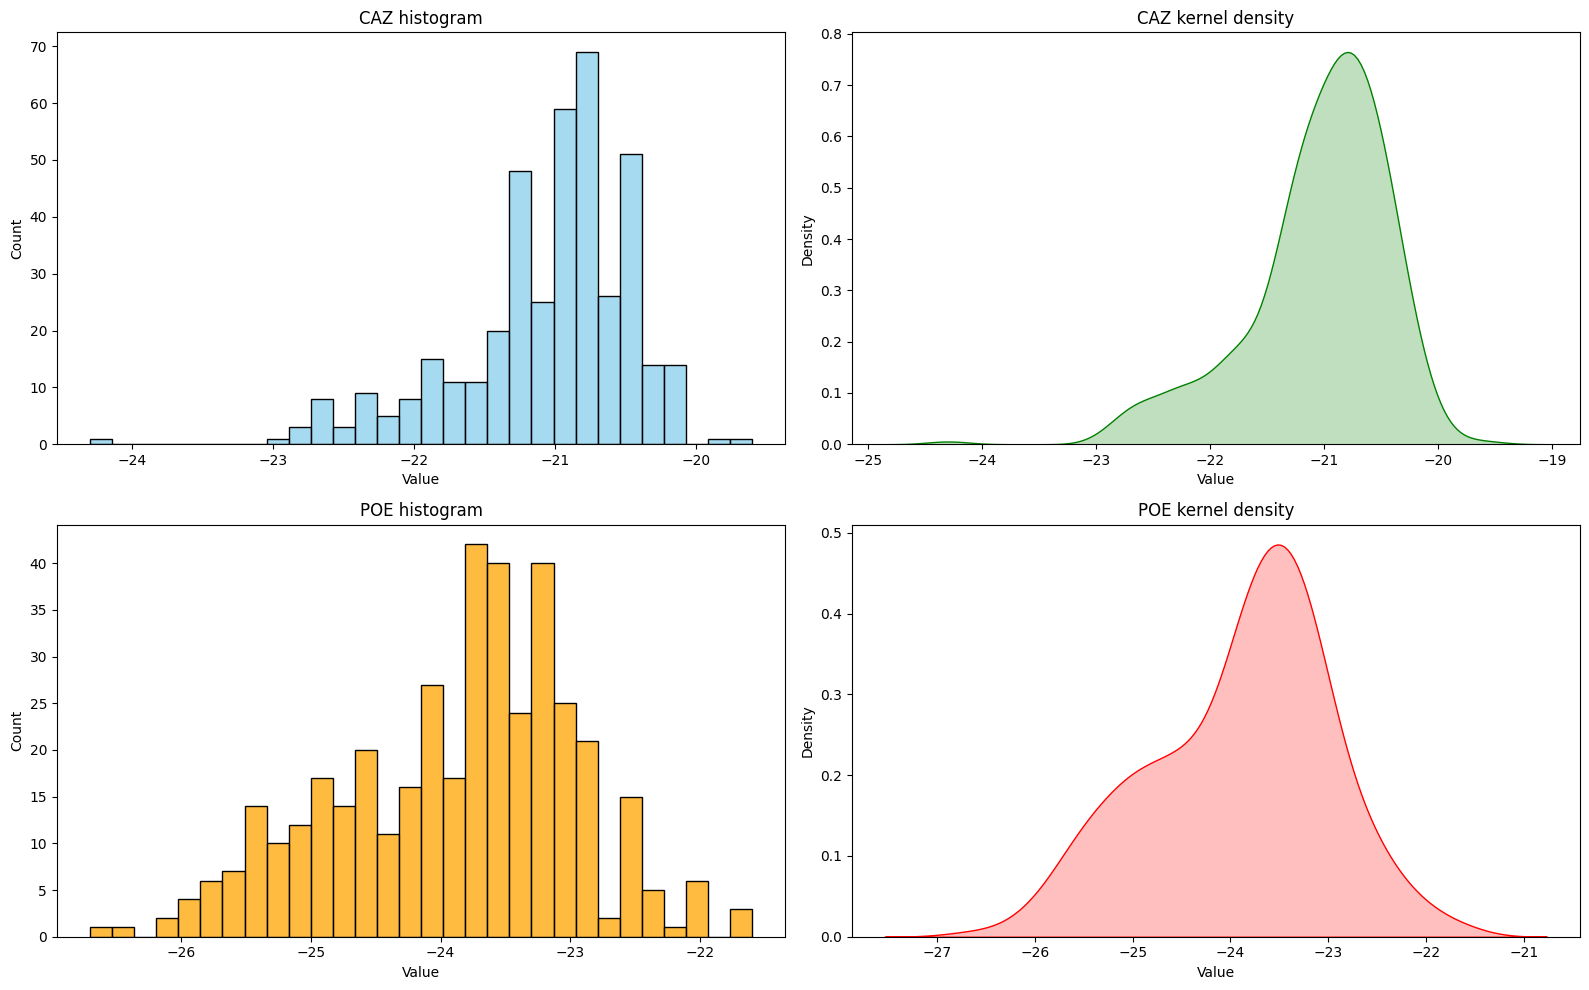

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Gráfica compuesta ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograma CAZ
sns.histplot(df_caz['Value'].dropna(), bins=30, kde=False, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title(f"CAZ histogram")
# Densidad kernel CAZ
sns.kdeplot(df_caz['Value'].dropna(), ax=axes[0, 1], color="green", fill=True)
axes[0, 1].set_title(f"CAZ kernel density")

# Histograma POE
sns.histplot(df_poe['Value'].dropna(), bins=30, kde=False, ax=axes[1, 0], color="orange")
axes[1, 0].set_title(f"POE histogram")
# Densidad kernel POE
sns.kdeplot(df_poe['Value'].dropna(), ax=axes[1, 1], color="red", fill=True)
axes[1, 1].set_title(f"POE kernel density")


plt.tight_layout()
plt.show()